 $$ Coursework-2-Natural  Language  Processing- (COMM061) $$

$$ Group-12$$

#### Video Representation Link : https://youtu.be/a68rZ21cikg 

### Introduction to the ChatterChef

ChatterChef is a friendly chatbot build for supporting with different queries related to restaurant. These queries could include reservation, good restaurant recommendation, food recommendation, help with the cooking, providing details of the ingradients and many other. ChatterChef can also take your booking for any  restaurant around and confirm the same instantly. 

ChatterChef has been build as a support for some online food aggregator business like uber eats, just eats etc.

### 1.The Architectural Choices

Coursework Part - II has been designed with the best performing model from Coursework -I.

Intent Classifier: A Support Vector Machine model that was trained on word vectors made using TF-IDF vectorization is the choice of intent classifier. Several model plus vectorization combinations were researched for use and few of them were tested before finalising one. Two methods of vectorization, one where the word vectors were relationally aware of each other (Doc2Vec) and one where they were purely numerised were tested. But since the vocabulary used in a restaurant query assistance chat is not very large, pure vectorization proved to be more than sufficient and accurate enough in our case. The Support Vector Machine algorithm used with TF-IDF word vectorization was able to predict the intent accurately in almost all situations.

Named Entity Recognition: A BiLSTM neural network with one-hot encoded input made from integer encoded word embedding. For NER, simple word embedding would sufficed as it only looks at individual words which might be important entities in that sentence. Therefore simple integer encoding of the vocabulary was the chosen method for vectorization. Two neural network models were tested for the choice of learning algorithms - LSTM and BiLSTM. Eventhough mostly similar, BiLSTM has the advantage of information flow in both directions as compared to LSTM. One-hot encoding was performed to make the word vectors compatible for input to the neural network. The effectiveness of the model was further improved with the addition of a time distributed layer (reduces model complexity) and a dropout layer (reduces chances of overfitting). Therefore, a BiLSTM with one-hot encoded word vectors served the model right for effective NER

Dialogue Flow: The flow of dialogue responses from the chatbot was architectured with a rule-based mechanism. Since this is a general-purpose chatbot, the questions asked and the responses from the chatbot has been implemented using different intents. This meant that a complex machine learnt text generation model was not necessary in our case and a rule-based response system served the purpose well. As the number of intents used is already 9, 'greeting' was not added in the classification model, but is used as a function which makes responses to greeting chats (which does not have many variations).Secondly, used cosine-similarity implemented in coursework- I where the model will find the most similar response with the message input provided by the user.

In [1]:
## importing required libraries
import json
import csv
import nltk
import string
import warnings
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import logging
import pickle
import re
import spacy

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics.pairwise import cosine_similarity
from flask import Flask, render_template, request
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from nltk.corpus import wordnet
from keras import layers
from keras import optimizers
from nltk.tokenize import word_tokenize
from tensorflow.keras import optimizers
from keras.models import Model
from tensorflow.keras.layers import Input

In [2]:
warnings.filterwarnings('ignore') ## removing warning messages

### Implementation of Model used for  Intent Classification

In [3]:
## Loading dataset for intent classification
with open("data_full.json") as f:
    data = json.loads(f.read())

In [4]:
##dividing the dataset into train,test and validate
train = pd.DataFrame.from_dict(data['train'])
val = pd.DataFrame.from_dict(data['val'])
test = pd.DataFrame.from_dict(data['test'])

In [5]:
train.columns = ['text','intent'] 
lst = ['restaurant_reservation','calories','nutrition_info','food_last', 'cook_time','ingredient_substitution','ingredients_list','meal_suggestion']
train = train[train.intent.isin(lst)]
val.columns = ['text','intent'] 
val = val[val.intent.isin(lst)]

test.columns = ['text','intent'] 
test = test[test.intent.isin(lst)]

In [6]:
oos_train = pd.DataFrame.from_dict(data['oos_train'])
oos_val = pd.DataFrame.from_dict(data['oos_val'])
oos_test = pd.DataFrame.from_dict(data['oos_test'])

In [7]:
oos_train.columns = ['text','intent']
oos_val.columns = ['text','intent']
oos_test.columns = ['text','intent']

In [8]:
train = pd.concat([train,oos_train], axis=0)
val = pd.concat([val,oos_val], axis=0)
test = pd.concat([test,oos_test], axis=0)

##### Below is the distribution of different intents in training data

we have used 10 different kind of intents to design our chatbot. 'OSS' here represents intent which doesn't fall in any of the categories.

In [9]:
train.intent.value_counts()

cook_time                  100
nutrition_info             100
meal_suggestion            100
oos                        100
ingredients_list           100
ingredient_substitution    100
calories                   100
restaurant_reservation     100
food_last                  100
Name: intent, dtype: int64

In [10]:
train.head() ### training data for intents

,text,intent
2400,you need to call the melt in lakewood for a ta...,restaurant_reservation
2401,"hey computer, make a reservation for 2 for my ...",restaurant_reservation
2402,i think we should reserve dad's regular table ...,restaurant_reservation
2403,"listen i need to get a reservation for , me an...",restaurant_reservation
2404,can you make me a reservation for 4 pm on the ...,restaurant_reservation


In [11]:
## text capturing example for intent oss
int_text =train.loc[train['intent'] == 'oos', 'text'] 
int_text.iloc[5]

'how is glue made'

In [12]:
## removing punctuation from test data
train['text_processed'] = list(map(lambda x:re.sub('[,\.!?]', '', x),train['text'])) # removing all symbols
train['text_processed'] = list(map(lambda x:x.lower(), train['text_processed']))

In [13]:
## lemmatizing the train data
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    if type(texts) == list:
        for sent in texts:
            doc = nlp("".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    else:
        doc = nlp("".join(texts)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out[0]
    return texts_out

In [14]:
lemmed_list = lemmatization(train['text_processed'].tolist(), allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
train['lemmatized_text'] = lemmed_list

In [15]:
#### vectorization of data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(lowercase= True, max_features=10000, ngram_range=(1,1), stop_words=ENGLISH_STOP_WORDS)
tfidf_vectorizer.fit(train.text)

TfidfVectorizer(max_features=10000,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}))

In [16]:
intent_le = LabelEncoder()

y_train = intent_le.fit_transform(train.intent.values)
train_idf = tfidf_vectorizer.transform(train.text)

In [17]:
Svm = SVC(gamma=0.5)

In [18]:
Svm.fit(train_idf, y_train)

SVC(gamma=0.5)

### Implementation of Model for Name Entity Recognition

In [19]:
### uploading dataset for name entity recognization
with open ('restaurant_intent_entities.json', 'r') as f:
    data_json = json.load(f)

In [20]:
### trimming dataset in csv format
def trim_json(data_json):
    list1=[]
    
    for key,value in data_json.items():
        for k,v in value.items():
            list1 = v.copy()
    return list1

header = []
data_1 = trim_json(data_json)
list2=[]
list3=[]
j=0
for i in data_1:
    j=j+1
    for c in i['entities']:
        list2.append(j)
        list2.append(i['text'])
        list2.append(c['entity'])
        list2.append(c['value'])
        list3.append(list2)
        list2=[]
with open ('restaurant_intent_entities.csv', 'w') as csv_f:
    csvwriter=csv.writer(csv_f)
    csvwriter.writerow(['sent#','text','entity','value'])
    csvwriter.writerows(list3)
csv_f.close()

In [21]:
## uploading dataset in csv format
data = pd.read_csv('restaurant_intent_entities.csv')
data.head()

,sent#,text,entity,value
0,1,book The Middle East restaurant in IN for noon,restaurant_name,The Middle East
1,1,book The Middle East restaurant in IN for noon,restaurant_type,restaurant
2,1,book The Middle East restaurant in IN for noon,state,IN
3,1,book The Middle East restaurant in IN for noon,timeRange,noon
4,2,Book a table at T-Rex distant from Halsey St.,restaurant_name,T-Rex


In [22]:
count = data.groupby("sent#")["value"].agg(["count"])
count = count.rename(columns={"count": "Value distribution in dataset"})

long_sent = count.max()[0]
long_sent_id = count[count["Value distribution in dataset"]==long_sent].index[0]

<b>Integer Encoding for Name Entity Recognition:</b>

In [23]:
###converting data values and entities into list
list_values = list(set(data["value"].values)) 
list_entities= list(set(data["entity"].values))

In [24]:
### Encoding entities and corresponding values using WordEmbedding
value2index = {value: idx for idx, value in enumerate(list_values)}
index2value = {idx: value for value, idx in value2index.items()}

entity2index = {entity: idx for idx, entity in enumerate(list_entities)}
index2entity = {idx: word for word, idx in entity2index.items()}

In [25]:
### removing punctuations from data values
list_values = [s.translate(string.punctuation) for s in list_values]
list_entities = [s.translate( string.punctuation) for s in list_entities]

### Ref: https://stackoverflow.com/questions/4371231/removing-punctuation-from-python-list-items

In [26]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arjoo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arjoo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arjoo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
### importing stop words from sklearn
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words

print(f"number of sklearn stopwords: {len(sklearn_stop_words)}")

#### importing stop words from nltk
import nltk
stop_words = nltk.corpus.stopwords.words('english')
print(f"number of nltk stopwords: {len(stop_words)}")

## merging nltk stopswords with sklearn stopwards to have a bigger list of stopwords
for elem in sklearn_stop_words:
    if not elem in stop_words:
        stop_words.append(elem)
print(f"number of merged stopwords: {len(stop_words)}")
print(stop_words[:10])

number of sklearn stopwords: 318
number of nltk stopwords: 179
number of merged stopwords: 378
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [28]:
##removing stop-words
data_values = [x for x in list_values if x not in stop_words]
data_entities = [x for x in list_entities if x not in stop_words]

In [29]:
###creating corpus of words and entities
def corpus(data):
    z = zip(data["value"].values.tolist(),
            data["entity"].values.tolist())
    return [(value,entity) for value,entity in z]

s = data.groupby("sent#").apply(corpus).tolist()

In [30]:
### Extracting list of values and entities from above corups
X = [[x[0] for x in m] for m in s]
Y = [[y[1] for y in m] for m in s]

<b>Indexing for training:</b>

In [31]:
##indexing the list for value and entities
X = [[value2index[x] for x in m] for m in X]
Y = [[entity2index[x] for x in m] for m in Y]

<b>One-hot Encoding implementation:</b>

In [32]:
count = len(entity2index)
Y = [np.eye(count)[s] for s in Y]

<b>Padding the train dataset: </b>

In [33]:
X = pad_sequences(X)
Y = pad_sequences(Y)

### Bi-LSTM Model implementation for NER

In [34]:
###Spliting dataset in proportion of 70%/30% for train/test
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=1234)

print("No. of sentence in training data: {}".format(len(X_train)))
print("No. of sentence in the test data : {}".format(len(X_test)))

No. of sentence in training data: 1381
No. of sentence in the test data : 592


<b>BiLSTM hyperparameters:<b>

In [35]:
tf.random.set_seed(0)
wc = len(value2index)
dense = 50
units = 50
do_lstm = 0.1
units_d = 14

In [36]:
## defining model
ip_layer = layers.Input(shape=(long_sent,))

model = layers.Embedding(wc, dense, embeddings_initializer="uniform", input_length=long_sent)(ip_layer)

model = layers.Bidirectional(layers.LSTM(units, recurrent_dropout=do_lstm, return_sequences=True))(model)

model = layers.TimeDistributed(layers.Dense(units_d, activation="relu"))(model)

final_model = Model(ip_layer, model)

opt = optimizers.Adam(learning_rate=0.001)

final_model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])

final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 embedding (Embedding)       (None, 8, 50)             115800    
                                                                 
 bidirectional (Bidirectiona  (None, 8, 100)           40400     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 8, 14)            1414      
 ibuted)                                                         
                                                                 
Total params: 157,614
Trainable params: 157,614
Non-trainable params: 0
_________________________________________________________________


In [37]:
## training the model
history = final_model.fit(X_train, y_train, batch_size=50, epochs=30, validation_split=0.1, verbose=2)

Epoch 1/30
25/25 - 11s - loss: 0.0275 - accuracy: 0.0762 - val_loss: 0.0253 - val_accuracy: 0.0836 - 11s/epoch - 447ms/step
Epoch 2/30
25/25 - 0s - loss: 0.0249 - accuracy: 0.3695 - val_loss: 0.0230 - val_accuracy: 0.5036 - 439ms/epoch - 18ms/step
Epoch 3/30
25/25 - 0s - loss: 0.0215 - accuracy: 0.4943 - val_loss: 0.0184 - val_accuracy: 0.5189 - 414ms/epoch - 17ms/step
Epoch 4/30
25/25 - 0s - loss: 0.0165 - accuracy: 0.5789 - val_loss: 0.0142 - val_accuracy: 0.6565 - 411ms/epoch - 16ms/step
Epoch 5/30
25/25 - 0s - loss: 0.0134 - accuracy: 0.7381 - val_loss: 0.0122 - val_accuracy: 0.7473 - 416ms/epoch - 17ms/step
Epoch 6/30
25/25 - 0s - loss: 0.0109 - accuracy: 0.8024 - val_loss: 0.0105 - val_accuracy: 0.7977 - 481ms/epoch - 19ms/step
Epoch 7/30
25/25 - 1s - loss: 0.0083 - accuracy: 0.8646 - val_loss: 0.0093 - val_accuracy: 0.7896 - 627ms/epoch - 25ms/step
Epoch 8/30
25/25 - 1s - loss: 0.0058 - accuracy: 0.9002 - val_loss: 0.0086 - val_accuracy: 0.8966 - 553ms/epoch - 22ms/step
Epoch 9/

### Training example for predicting intent and NER from same sample statement

In [38]:
text = 'book midday at halal place for five at a bakery or restaurant in Sugarville'

def predictor(text):
    list_text = []
    list_text.append(text)
    vec = tfidf_vectorizer.transform(list_text)
    intent = Svm.predict(vec)
    
    tok = re.compile(f"([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])") ### removing punctuation
    sent = tok.sub(r"  ", text).split() ## tokenization
    sent = [x for x in sent if x not in stop_words] ### removing stop-words
    value2index["--PADDING--"]=1
    p_sent = sent + [value2index["--PADDING--"]] * (long_sent - len(sent)) ## padding sentence
    p_sent = [value2index.get(w, 0) for w in p_sent]
    pred = final_model.predict(np.array([p_sent])) ## feeding into model
    pred = np.argmax(pred, axis=-1)
    
    ret = ""
    for a, b in zip(sent, pred[0]):
        ret = ret + "{:15}: {:5}".format(a, index2entity[b]) + "\n"
    return (print('Intent: ',intent_le.inverse_transform(intent)), print('\nEntities: \n',ret))

predictor(text)

1/1 [==============================] - 1s 1s/step
Intent:  ['oos']

Entities: 
 book           : facility
midday         : timeRange
halal          : cuisine
place          : facility
bakery         : restaurant_type
restaurant     : restaurant_type
Sugarville     : city 



(None, None)

From above example we can see that our intent and NER model is able to predict intent and NER from the sample problem. Since the intent is 'OSS' which represents Out of Scope, we are going to handle this condition while defining our chatbot. Secondly, Accuracy of recongizing entities is less i.e., for example here model has predicted book as city and place as timeRange. We are also going to take care of these scenarios where accuracy of NER is less while defining NER inside our chatbot.

Accuracy of intent and NER is less because of limited dataset to train. If we will increase the size of dataset the accuracy would improve.

In [39]:
y_test1 = np.argmax(y_test, axis=2)

###  Dialogue Flow Manager

Created different functions for different types of expected inputs from user and storing in line responses to those inputs. Here, our dataset doesn't had any response stored in it, we have created a response file with responses to different types of queries which will be responded using cosine similarity between the input and the sentence from the response file.

For responses falling into intent category, we have created functions to handle such situation. if user input falls in 'OSS' Intent,the response will be as per cosine similarity from the response file.

For NER, the function is picking the user-input, running the NEW BiLSTM model on it and predict the entities. If accuracy of recognizing the entity is less than 10%, model will not return NER from the function.

#### I. Handling Greetings 

In [40]:
# taking synonyms of hello from wordnet synonyms set and appending in a list
syn = []
for s in wordnet.synsets('hello'):
    for l in s.lemmas():
        lname = re.sub(r'\[[0-9]*\]', ' ', l.name())
        lname = re.sub(r'\s+', ' ', l.name())
        syn.append(lname)

In [41]:
# taking greeting inputs and corresponding possible responses from chatbot
greetings = ['hi','hey', 'hello', 'whats up', 'good evening', 'good morning', 'hey there']
# concatenating the synonyms and the inputs for greeting
greetings = greetings + syn
# greeting responses by the bot
greetings_resp = ['Hi! How can I help you?',
                      'Hello there! So please what do you want to know?',
                      'Hi, How can I assist you today?']

#### II. Some general conversation

In [42]:
### taking some more basic converation
convos = ['how are you', 'how are you doing today', 'you good ?']
# possible responses by chatbot
convos_resp = ['Great! what about you?', 'Just having a busy day :( wbu??', 'Just enjoying my work :)']
# possible replies by user
convos_user = ['great', 'i am fine', 'fine', 'good', 'super', 'superb', 'super great', 'nice']

In [43]:
# other basic qus and ans related to chatbot (chatterchef)
ques_ans = {'what are you': 'I am a restaurant bot. Here to help you for food and restaurant recommendation :3',
                    'who are you': 'I am a restaurant bot. Here to help you for food and restaurant recommendation :3',
                    'what can you do': 'Recommending restaurant and food!'}

#### III. Loading response file and pre-processing 

In [44]:
## Loading responses file 
with open ('restaurant_response_dataset.txt', 'r') as f:
    d_data = f.read()

In [45]:
# Lower casing the data
t_data = d_data.lower()

In [46]:
# removing special characters from response data
t_data = re.sub(r'\[[0-9]*\]', ' ', t_data)
t_data = re.sub(r'\s+', ' ', t_data)

In [47]:
# extracting sentences from the response data
sentences = nltk.sent_tokenize(t_data)
# extracting words from the response data
words = nltk.word_tokenize(t_data)

In [48]:
# applying lemmatization on words
lem = nltk.stem.WordNetLemmatizer()
def per_lem(tokens):
    return [lem.lemmatize(token) for token in tokens]

In [49]:
rem_punc = dict((ord(p), None) for p in string.punctuation)

In [50]:
# method for pre-processing as per above functions
def proc_data(doc):
    return per_lem(nltk.word_tokenize(doc.lower().translate(rem_punc)))

In [51]:
# removing punctuation
def punc_rem(str):
    punc = r'''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punc = ''

    for c in str:
        if c not in punc:
            no_punc = no_punc + c

    return no_punc

#### iv. Function to tackle the greetings for the chatbot

Since our chatbot doesn't have any intent for recognizing greetings. We have created a function which will tackle the greetings inputs from user.

Here, greeting function will pick the greeting meessages and as above we have picked different synonyms of greeting words and this function will pick a random response to return and render the same to user.

In [52]:
# function for greetings
def greeting(hello):
    if punc_rem(hello.lower()) in greetings:
        return random.choice(greetings_resp)

#### v. Function to handle general conversation and basic qus/ans

In [53]:
# function for responsing
def convo_resp(str):
    if punc_rem(str.lower()) in convos:
        return random.choice(convos_resp)

In [54]:
# function for qus and ans
def qus_ans(str):
    if punc_rem(str.lower()) in ques_ans:
        return ques_ans[punc_rem(str.lower())]

#### vi. Function to capture intent for the input message

Below function will pick the message input by user and by using our best performing intent model i.e.,SVM with TF-IDF will predict the intent for the message.

We have added an additional intent here called 'OSS' (Out of Scope) to handle the inputs which doesn't belong to any intent.

In [55]:
### Get Intent for the input provided by the user
from nltk.corpus import stopwords
sw = stopwords.words('english')
def get_intent(u_ip):
    text = []
    text.append(u_ip)
    vec = tfidf_vectorizer.transform(text)
    intent_vec = Svm.predict(vec)
    intent = intent_le.inverse_transform(intent_vec)
    return intent

In [56]:
### Intent capturing example
example = "need to book a table at Taj Mahal"
int_exam = get_intent(example)
print (int_exam)

['restaurant_reservation']


Here we can see our model is able to predict intent correcly for a reservation request.

#### vii. Function to capture NER for the input message

Below function is defined to handle the NER part of the chatbot. It will pick the message from the user and will pass trough the BiLSTM model to predict the entities present in the message.

Here, since our dataset size was limited and the model was trained with limited data, prediction of the entity is going to be very limited. Hence we have defined our function in such a way that it will return entities, if only the accuracy of entity recognition  is more than 10% w.r.t. to our test data. Otherwise will return oss i.e., Out of Scope.

In [57]:
##function defined to capture entities
def get_ner(u_ip):
    tok = re.compile(f"([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])")
    u_ip = tok.sub(r" ", u_ip).split()
    sent = [x for x in u_ip if x not in stop_words]
    value2index["--PADDING--"]=1
    p_sent = sent + [value2index["--PADDING--"]] * (long_sent - len(sent))
    p_sent = [value2index.get(w, 0) for w in p_sent]
    pred = final_model.predict(np.array([p_sent])) ## feeding into model
    pred = np.argmax(pred, axis=-1)
    y_test1 = np.argmax(y_test, axis=-1)
    accuracy = (pred == y_test1).mean()
    #print ("Accuracy: {:.3f}/".format(accuracy))
    ret = ""
    for a, b in zip(sent, pred[0]):
        ret = ret + "{:2}: {:2}".format(a, index2entity[b])+ "    "
    if accuracy >= 0.10:
        return ret
    else:
        return 'oos'

In [58]:
## example for recongizning entities
example = "book the Middle East restaurant in IN for noon"
get_ner(example)

1/1 [==============================] - 0s 41ms/step


'book: facility    Middle: facility    East: facility    restaurant: restaurant_type    IN: state    noon: timeRange    '

In above example, prediction was good for timeRange, restaurant_type, state and city. But book has been captured as city. It is because the dataset for entity is very biased with few type of entities.

#### viii. Function to generate response from response file

Below function has been created to generate response for the input message which doesn't fall in any category of intent classification. We have created a response file with the multiple text sentences of expected responses by the user. And we are using cosine- similarity to find the similarity between the query by user and sentences from response file to find the best suitable response for the query.

In [59]:
# function to fetch response from response file
def recommendation(user):
    bot_resp = ''
    sentences.append(user)

    w_vect = TfidfVectorizer(tokenizer=proc_data, stop_words='english')
    word_vect = w_vect.fit_transform(sentences)
    sim_vect = cosine_similarity(word_vect[-1], word_vect)
    sim_sent = sim_vect.argsort()[0][-2]

    mat_vect = sim_vect.flatten()
    mat_vect.sort()
    vect_mat = mat_vect[-2]

    if vect_mat == 0:
        bot_resp = bot_resp + 'Sorry, I can\'t help you with this. You can check out our website for further details. '
        return bot_resp
    else:
        bot_resp = bot_resp + sentences[sim_sent]
        return bot_resp

#### ix. Function to chat with the ChatterChef

Here we have merged all the functions created above to provide the best suitable response to the user. A component has been added to check for the intent and provide the response according the the intent value only. 

Another component has been created to capture the entities present in the input messaage and print the same in the log.

using above all components and cosine similarity with responses stored, the best suitable next action for the chatbot will be triggered.

In [60]:
# chatting with the chatbot -->

def user_chat(u_ip):
    response = ""
    print ('User input:',u_ip)
    u_ip = punc_rem(u_ip)
    intent = get_intent(u_ip)
    print ('intent:',intent)
    entity = get_ner(u_ip)
    print ('entity:', entity)
    if u_ip != 'bye':
        if u_ip == 'thanks' or u_ip == 'thank you very much' or u_ip == 'thank you':
            response =  'happy to help ! (And WELCOME! :D)'
        elif u_ip in convos_user:
            response = 'That\'s nice! How can I help you?'
        else:
            if greeting(u_ip) is not None:
                response = greeting(u_ip)
            elif convo_resp(u_ip) is not None:
                response = convo_resp(u_ip)
            elif qus_ans(u_ip) is not None:
                response =  qus_ans(u_ip)
            elif intent == ['oos']:
                response = recommendation(u_ip)
            elif intent == ['restaurant_reservation']:
                response = 'Your reservation has been confirmed for tonight. Booking ID: D$3XZ1. Please provide booking ID at recepetion.'
            elif intent == ['nutrition_info']:
                response = 'For nutrition related guidance please visit our website sub-section :Nutrition-Guidance.'
            elif intent == ['food_last']:
                response = 'It totally depends upon the content of the food. Milk last for approx. 3 days while the egg expires in 10 days.'
            elif intent == ['cook_time']:
                response = 'baking time for cake is approx 1 hour.'
            elif intent == ['ingredient_substitution']:
                response = 'yes! we will add chicken in place of bacon.'
            elif intent == ['calories']:
                response = 'For calories related guidance please visit our website sub-section :Calories-Guidance.'
            elif intent == ['ingredients_list']:
                response = 'Ingradients in the dish are mentioned under the dish description at our website for easy access.'
            elif intent == ['meal_suggestion']:
                response = "We do have too many good options to choose from. I can recommend you as:NON_VEG: Piri Piri Chicken Salad, Lamb doner,Chicken Shish. VEG: Green Salad, Regular fries, Onion Rings. Dessert: Strawberry & Chocolate Waffle, Mixed Ice Cream. Drinks: Banana Milkshake, Belgian Chocolate Milkshake."
            elif qus_ans(u_ip) is not None:
                response =  qus_ans(u_ip)
            else:
                #print('Chatterchef: ', end='')
                response = recommendation(u_ip)
                sentences.remove(u_ip)
    else:
        response = 'Bye, take care, stay happy and stay safe!'
    print ('ChatterChef Response:',response)
    return response

### 2. Designing web service using flask, hosting models implemented for intent and Entities

This chatbot application called 'ChatterChef' has been build using flask web-based framework. ChatterChef is handling all the components as described below:

1. Intent classification has been done and response corresponding to each intent is stored which will be triggerd only if the input message lies in that Intent.


2. Entity Recognition has been done for the input provided by the user using the Bi-LSTM model implemnted.


3. A response has been generated using the cosine-simailarity and different functions created to handle different scenarios.


4. All the components are brought together to depict the best suitable response based on the accuracy of intent classification and cosine similarity with the response stores. Greetings and generic queries are handled using defined functions with stored responses.

#### Web App Design for ChatterChef

We have designed ChatterChef bot using Flask Framework. To capture the input message and provide the response to the user functions has been created with defined route for the chatbot.

To design the chatbot inside flask app, we have created template and static folders. Template folder will have the html page, which will act as the frontend for the chatbot while static folder contains styles.css file which is used to style the layout of the frontend.

app.run() method used at the end is used to find the instance of your application and run the same on the defined path.

### 3. Testing on the deployed application

### a. Initiate the chatbot :

created a function to handle the greeetings. Hello word synonyms has been captured from wordnet and as per these inputs, responses are stored in a directory which will be randomly picked and reverted back to the user.
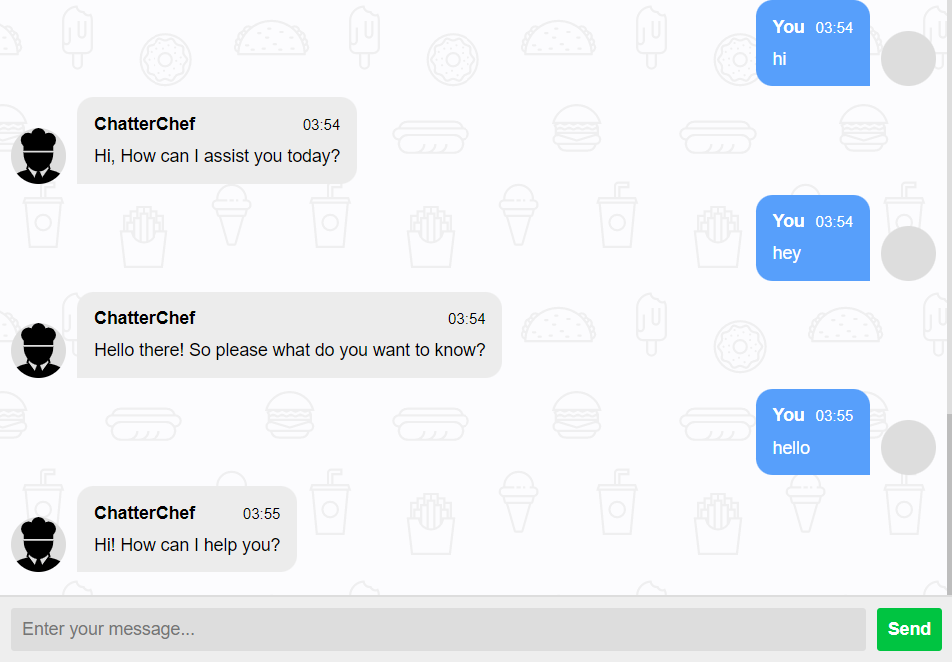

### b. make different types or requests (i.e., different intents)

Different responses has been created according to different intents. Function will capture the intent corresponding to the message input and provide the response accordingly.

If intent is 'OSS' i.e., Out of Scope, the response will be fetched from the response file as per cosine similarity.

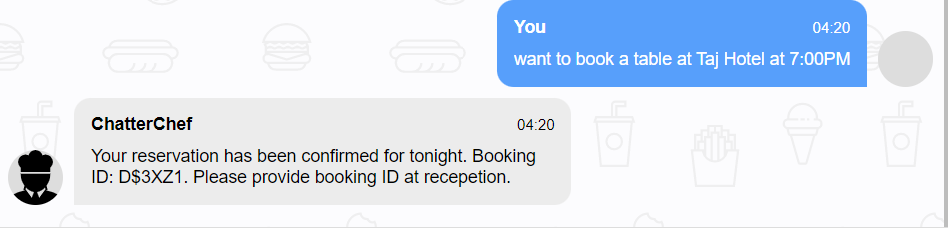
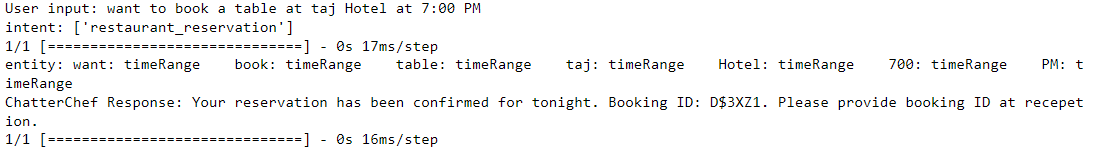
#### Above Images show that for reservation request Intent 'restaurant_reservation' has been triggered.
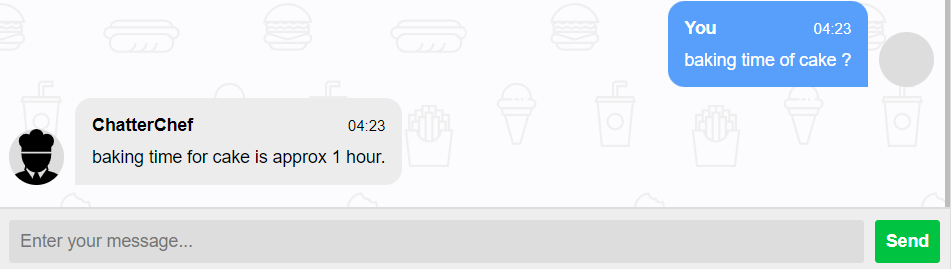
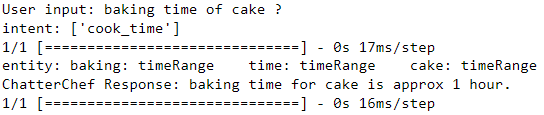
#### Above query triggered "cooking_time" intent and correspong output.
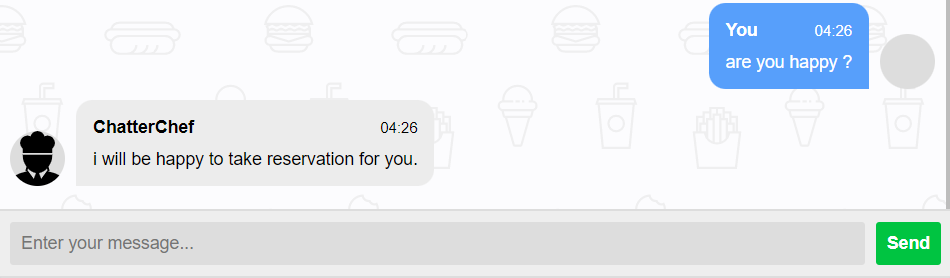
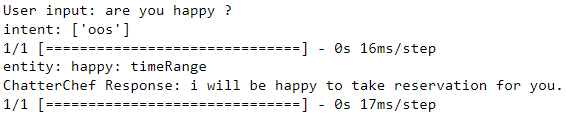
#### Here, since intent is 'OSS' response from the response file has been captured.

### c. try to confuse it and see the reaction

If user query doesn't fall under any intent, doesn't have similarity with the responses captured, is not greeting or general conversation, a response has been defined directing user to connect with web-site.
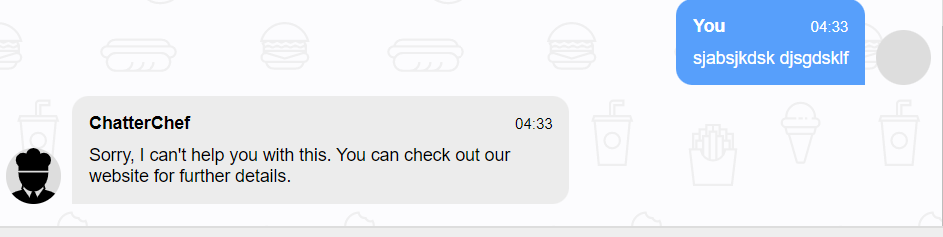

#### User has given gibberish input message and chatbot has redirected the user to website.

### d. try to override a previous entry 

#### Here, If user want to change the booking same has been handled using cosine-similarity. different responses are stored which will be triggered when user need to update the booking.

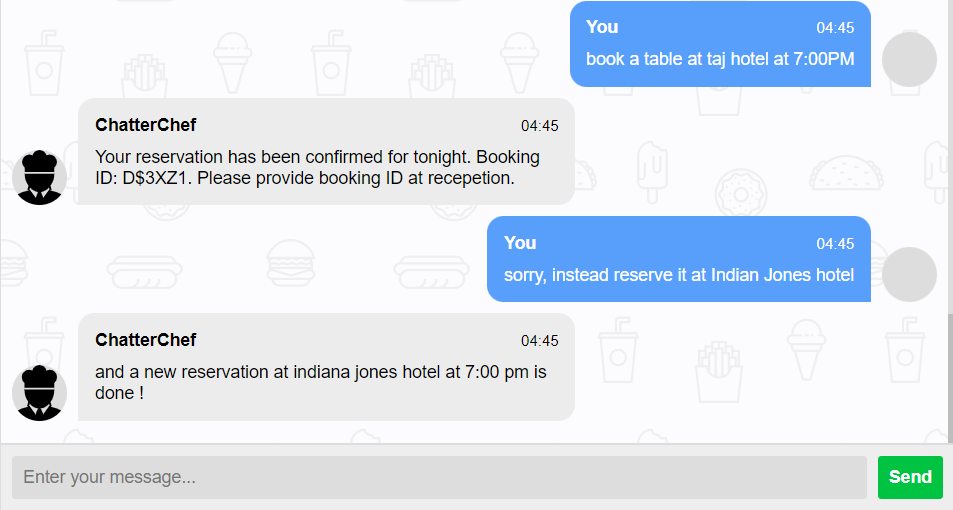

#### Below image show that for first reservation, the response is corresponding to Intent "restaurant_reservation" while for the override request to update the location of reservation is handled by cosine-similarity for 'OSS' Intent.

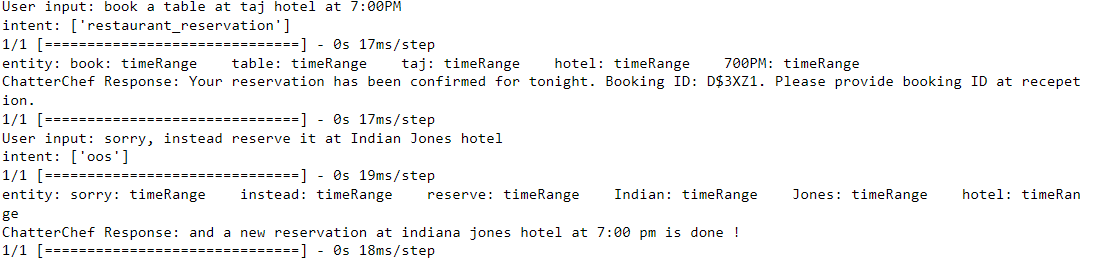

### e. show a completed successful request

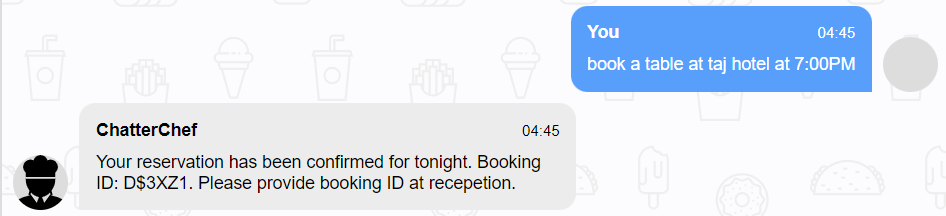

#### Above shows a successful booking for user at a restaurant.

### 4. Performance of the chatbot

Performance of the chatbot was very limited because of the limited dataset used. If the model would have been trained on large size of data, the prediction of response would have been better. Secondly a large number of intents to distinguish the message input was also challenging.

Use of cosine-simialrity for providing response helped the model to predict the responses more accurately. Including a new Intent 'OSS' helped model to predict responses for queries which doesn't belong to any intent. Below are the few good and bad points captured during testing:

#### Good Points:
1. Chatbot is able to distinguish 9 intents and provide different- different responses for each intent.
2. For message which doesn't fall in any intent, response of those inputs are also handled.
3. Any type of greeting has been captured.
4. If chatbot doesn't understand any message, response for those scenarios are also included.

#### Bad points:
1. Responses for intents are limited and hence queries can also be limited. If user going to provide input for which no response has been captured, user will get only the response available which could be irrelevent.
2. With cosine similarity, sometimes responses doesn't make sense to the query but because of the similarity of sentence, user will get that response.

### 5. Log system design for monitoring

Using werkzeug and Filehandler() class, the log system has been implemented for the monitoring purposes. Werkzeug is a utliity library which is used in the model to provide access to the data inside flask and Filehandler() is used to write the logs in a file i.e., 'log.log' file.

In this log.log file, we are capturing the user message-Input, intent, entities presentand the response provided by the chatbot. It also captures the message sent via http and via which path. Reference Image of logs is provided below where Intent is captured as 'OSS', then multiple entities are present, then response from chatbot and finally the request triggered has been also captured.

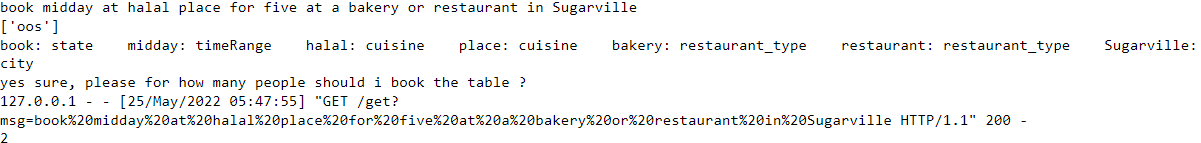

### 6. CI-CD pipeline for the application

All components for the chatbot are defined inside the NLP_CourseWork-2_Group-12.ipynb python file and app.run() function is also defined in the same file.
So if there is any change or upgrade in the execution part of components the same file need to run again and the application will be updated.
Secondly if we need to train our chatbot with more data for better accuracy same can alos be handled directly from NLP_CourseWork-2_Group-12.ipynb python file.

It provides continous Integration of all the components and easy deployment to the changes, with running of a single python file. 

ChatterChef has been accessed by using local host on http with 5000 port. URL : http://127.0.0.1:5000/

### 7. Video Representation Link to demonstrate solution

### https://youtu.be/a68rZ21cikg

In [62]:
app = Flask(__name__)
app.static_folder = 'static'
logger = logging.getLogger('werkzeug') 
handler = logging.FileHandler('log.log') 
logger.addHandler(handler) 
@app.route("/")
def home():
    return render_template("index.html")
@app.route("/get")
def get_bot_response():
    u_ip = request.args.get('msg')
    response = user_chat(u_ip)
    intent = get_intent(u_ip)
    entity = get_ner(u_ip)
    logger.info(u_ip)
    logger.info(intent)
    logger.info(entity)
    logger.info(response)
    return response

if __name__ == "__main__":
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
User input: hi
intent: ['oos']
1/1 [==============================] - 0s 40ms/step
entity: hi: facility    
ChatterChef Response: Hi, How can I assist you today?
1/1 [==============================] - 0s 42ms/step
User input: how are you
intent: ['oos']
1/1 [==============================] - 0s 53ms/step
entity: 
ChatterChef Response: Great! what about you?
1/1 [==============================] - 0s 44ms/step
User input: good.
intent: ['meal_suggestion']
1/1 [==============================] - 0s 96ms/step
entity: good: facility    
ChatterChef Response: That's nice! How can I help you?
1/1 [==============================] - 0s 28ms/step
User input: book midday at halal place for five at a bakery or restaurant in Sugarville
intent: ['oos']
1/1 [==============================] - 0s 27ms/step
entity: book: facility    midday: timeRange    halal: cuisine    p

### References :

1. https://stackoverflow.com/questions/58984330/python-flask-print-to-console-and-log-file-simultaneously
2. https://flask.palletsprojects.com/en/1.0.x/logging/
3. https://medium.datadriveninvestor.com/building-a-machine-learning-chat-bot-with-flask-framework-and-python-2c24b2def49b
4. https://python.plainenglish.io/create-a-deep-learning-chatbot-with-python-and-flask-d75396a4382a
5. https://buffml.com/web-based-chatbot-using-flask-api/